In [13]:
import ast
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from collections import Counter

In [14]:
df = pd.read_csv("data/traficogt_clean.csv")
df.shape, df.columns.tolist()[:10]

((5596, 22),
 ['fecha_gt',
  'hora_gt',
  'anio',
  'mes_num',
  'mes_nombre',
  'dia_semana',
  'hora',
  'id',
  'user.username',
  'rawContent'])

# Construcción del grafo dirigido

In [ ]:
def parse_list(s):
    if isinstance(s, str):
        try:
            v = ast.literal_eval(s)
            return v if isinstance(v, list) else []
        except Exception:
            return []
    return []

pairs = []  

for _, r in df.iterrows():
    u = str(r["user.username"]).lower().strip()

    # menciones
    for v in parse_list(r.get("mentions")):
        v = str(v).lower().strip()
        if v and u and u != v:
            pairs.append((u, v, "mention"))

edge_counts = Counter((u, v) for u, v, _ in pairs)
edge_types   = Counter((u, v, t) for u, v, t in pairs)

len(edge_counts), len(edge_types)


(7335, 7335)

In [16]:
G = nx.DiGraph()
for (u, v), w in edge_counts.items():
    G.add_edge(u, v, weight=w)

nodes_df = pd.DataFrame({"user": list(G.nodes())})
edges_df = pd.DataFrame([(u, v, d["weight"]) for u, v, d in G.edges(data=True)],
                        columns=["source","target","weight"])

nodes_df.to_csv("data/nodes.csv", index=False)
edges_df.to_csv("data/edges.csv", index=False)

G.number_of_nodes(), G.number_of_edges()


(2720, 7335)

In [ ]:
W_MIN = 0       
K_CORE = 5      
TOP_LABELS = 30 

# aristas débiles
H = nx.DiGraph(((u, v, d) for u, v, d in G.edges(data=True) if d.get("weight",1) >= W_MIN))

# componente gigante
UG = H.to_undirected()
giant = H.subgraph(max(nx.connected_components(UG), key=len)).copy()

# k-core en no dirigido
core_nodes = nx.k_core(giant.to_undirected(), k=K_CORE).nodes()
H = giant.subgraph(core_nodes).copy()

H.number_of_nodes(), H.number_of_edges()


(459, 2774)

In [ ]:
deg = dict(H.degree())
btw = nx.betweenness_centrality(H.to_undirected(), k=min(1000, H.number_of_nodes()), seed=42)

top_nodes = sorted(deg, key=deg.get, reverse=True)[:TOP_LABELS]
node_size = [max(80, deg[n]*10) for n in H.nodes()]
edge_width = [0.5 + H[u][v]["weight"]*0.25 for u, v in H.edges()]


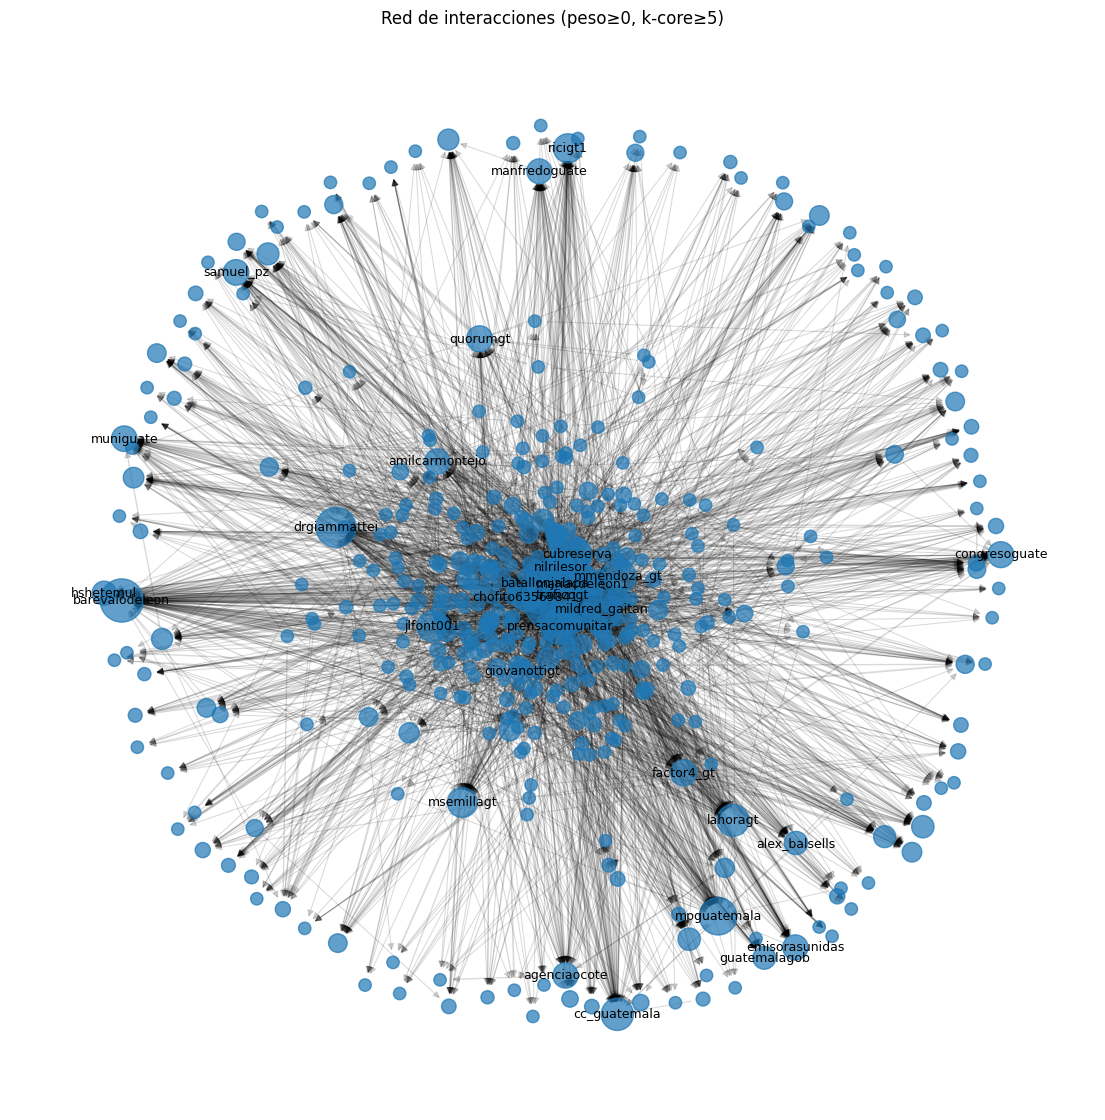

In [24]:
pos = nx.spring_layout(H, k=0.35, iterations=100, seed=7)

plt.figure(figsize=(14,14))
nx.draw_networkx_edges(H, pos, alpha=0.15, arrows=True, width=edge_width)
nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color="tab:blue", alpha=0.7)
nx.draw_networkx_labels(H, pos, labels={n:n for n in top_nodes}, font_size=9)
plt.title(f"Red de interacciones (peso≥{W_MIN}, k-core≥{K_CORE})")
plt.axis("off")
plt.show()


La red con `W_MIN=0` y `k-core=5` muestra un **núcleo central muy denso** donde destacan cuentas como **@traficogt, @prensacomunitar, @drgiammattei, @amilcarmontejo** y **@muniguate**, que concentran la mayoría de interacciones y funcionan como **hubs de información**. Alrededor de ellas se forman comunidades más pequeñas, mientras que los usuarios periféricos mantienen conexiones limitadas. Esto evidencia que la conversación está fuertemente centralizada en pocos actores influyentes que articulan y amplifican la discusión pública sobre el tráfico en Guatemala.


# Metricas

In [ ]:
densidad = nx.density(H)  

HU = H.to_undirected()
if nx.is_connected(HU):
    diametro = nx.diameter(HU)
else:
    comp = HU.subgraph(max(nx.connected_components(HU), key=len)).copy()
    diametro = nx.diameter(comp)

clustering = nx.average_clustering(HU)

print(f"Densidad: {densidad:.5f}")
print(f"Diámetro: {diametro}")
print(f"Coeficiente de agrupamiento: {clustering:.4f}")


Densidad: 0.01320
Diámetro: 4
Coeficiente de agrupamiento: 0.1842


La red presenta una densidad de 0.0132, lo que indica que solo una pequeña fracción de los enlaces posibles está presente; es una red dispersa, como suele ocurrir en interacciones de twitter. El diámetro de 4 muestra que cualquier usuario puede llegar a otro en muy pocos pasos, evidenciando una red relativamente eficiente en la propagación de información. Finalmente, el coeficiente de agrupamiento de 0.1842 señala que existen clústeres locales donde los usuarios tienden a interactuar dentro de grupos, reforzando la presencia de comunidades en torno a ciertos actores centrales.

# Comunidades y “relaciones de poder”

In [26]:
from networkx.algorithms.community import greedy_modularity_communities

communities = list(greedy_modularity_communities(H.to_undirected()))
len(communities), [len(c) for c in communities[:5]]

(9, [132, 96, 95, 81, 19])

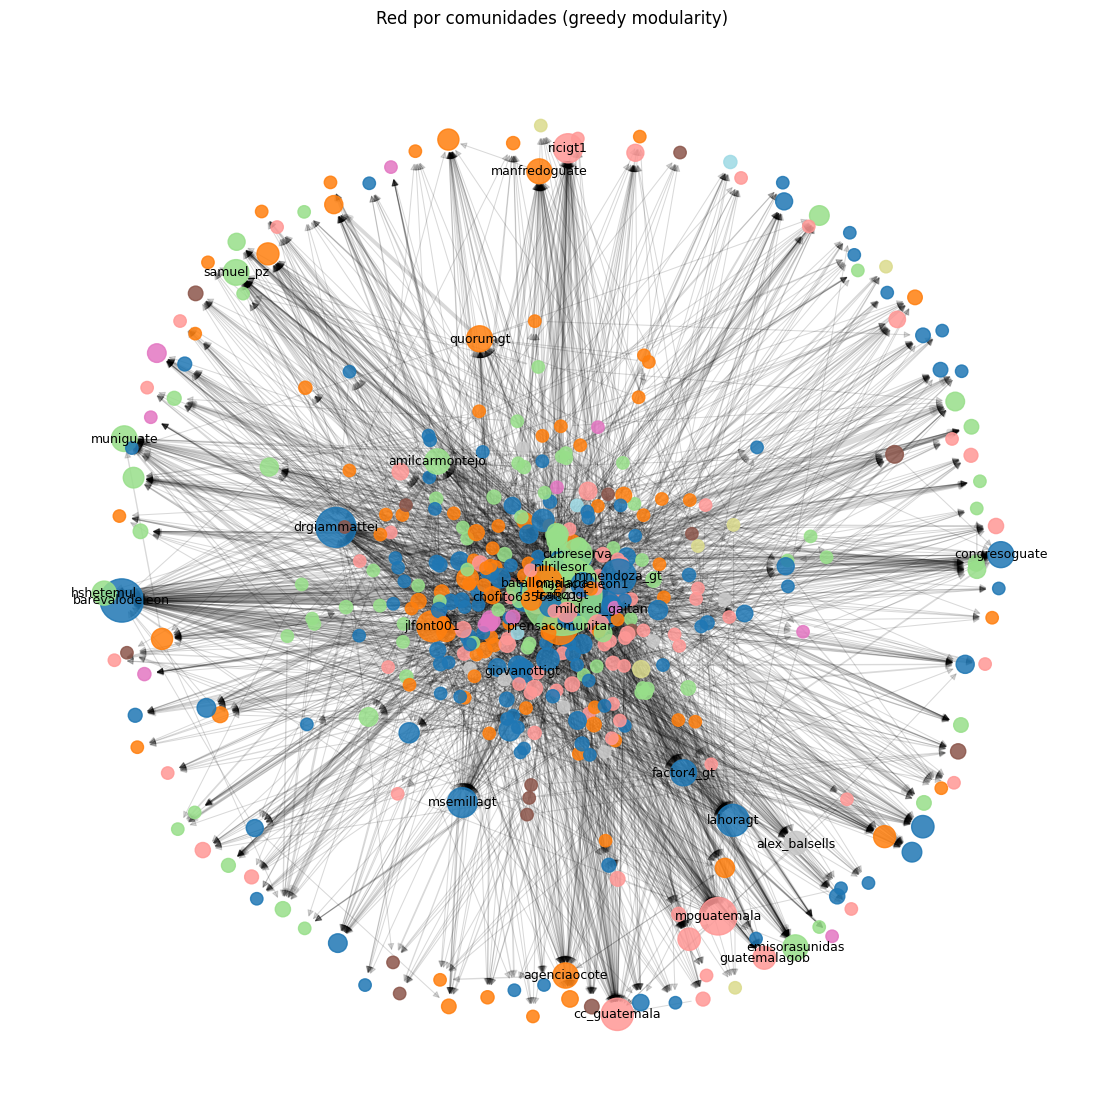

In [28]:
comm_index = {}
for i, com in enumerate(communities):
    for n in com:
        comm_index[n] = i

colors = [comm_index.get(n, -1) for n in H.nodes()]
plt.figure(figsize=(14,14))
nx.draw_networkx_edges(H, pos, alpha=0.15, arrows=True, width=edge_width)
nx.draw_networkx_nodes(H, pos, node_size=node_size, node_color=colors, cmap="tab20", alpha=0.85)
nx.draw_networkx_labels(H, pos, labels={n:n for n in top_nodes}, font_size=9)
plt.title("Red por comunidades (greedy modularity)")
plt.axis("off")
plt.show()

El análisis de comunidades mediante **greedy modularity** reveló **9 grupos principales** de usuarios, con tamaños que van desde 132 hasta 19 miembros. Esto muestra que la red, aunque concentrada en un núcleo central, se organiza en **subgrupos cohesivos** alrededor de cuentas influyentes como actores políticos, medios y autoridades. En estos clústeres los usuarios interactúan más entre sí que con el resto de la red, lo que refleja **audiencias diferenciadas** y focos de conversación específicos dentro del tema general del tráfico en Guatemala.